In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization, Dropout, Layer, LSTM, Input

In [2]:
dann_data = pd.read_csv('dann_nelec_elec.csv')

In [19]:
EPOCH = 100

##  For Scaling

In [5]:
X = dann_data.iloc[:,:-3]
Y = dann_data.iloc[:,-3:]

scaler = MinMaxScaler()
scaler.fit(X)
scaled_x = scaler.transform(X)

new_x = pd.DataFrame(scaled_x, index=X.index, columns=X.columns)
new_dann_data = pd.concat([new_x, Y], axis=1)

In [9]:
data_input = new_dann_data.iloc[:,:-3]
s_label = new_dann_data[['N_ELEC']]
d_label1 = new_dann_data[['ELEC']]
d_label2 = new_dann_data[['N_ELEC2']]

### Source vs Target (Train_Test_Split)

In [11]:
split_for_data_input = int(len(data_input)*0.7)
data_input_trainX = data_input[:split_for_data_input]
data_input_testX = data_input[split_for_data_input:]

split_for_s_label = int(len(s_label)*0.7)
s_label_trainX = s_label[:split_for_s_label]
s_label_testX = s_label[split_for_s_label:]

split_for_d_label1 = int(len(d_label1)*0.7)
d_label1_trainX = d_label1[:split_for_d_label1]
d_label1_testX = d_label1[split_for_d_label1:]

split_for_d_label2 = int(len(d_label2)*0.7)
d_label2_trainX = d_label2[:split_for_d_label2]
d_label2_testX = d_label2[split_for_d_label2:]

### (Rows, Window_Size, Column) 3차원으로 변환

In [ ]:
# def buildDataSet(input, target, seqLength):
#     xdata = []
#     ydata = []
#     for i in range(len(input) - seqLength):
#         tx = input.iloc[i:i+seqLength]
#         ty = target.iloc[i+seqLength-1]
#         xdata.append(tx)
#         ydata.append(ty)
#     return np.array(xdata), np.array(ydata)

In [33]:
#Prepare Datasets
BATCH_SIZE = 64
source_dataset = tf.data.Dataset.from_tensor_slices((data_input_trainX, s_label_trainX)).batch(BATCH_SIZE*2)
da_dataset = tf.data.Dataset.from_tensor_slices((data_input_trainX, s_label_trainX, data_input_trainX, s_label_trainX)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((data_input_testX, d_label1_testX)).batch(BATCH_SIZE*2) #Test Dataset over Target Domain
test_dataset2 = tf.data.Dataset.from_tensor_slices((data_input_trainX, d_label1_trainX)).batch(BATCH_SIZE*2) #Test Dataset over Target (used for training)

### DANN

In [34]:
@tf.custom_gradient
def gradient_reverse(x, lamda=1.0):
    y = tf.identity(x)
    
    def grad(dy):
        return lamda * -dy, None
    
    return y, grad

class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def call(selx, x, lamda=1.0):
        return gradient_reverse(x, lamda)
    
class DANN(Model):
    def __init__(self):
        super().__init__()
        
        # Feature Extractor
        self.feature_extractor_layer0 = LSTM(64, activation='swish', return_sequences=True),
        self.feature_extractor_layer1 = Dropout(0,3)
        self.feature_extractor_layer2 = LSTM(64, activation='swish', return_sequences=False)
        
        # Label Predictor
        self.label_predcitor_layer0 = Dense(64, activation='relu')
        self.label_predcitor_layer1 = Dense(1, activation='relu')
        
        # Domain Predictor
        self.domain_predictor_layer0 = GradientReversalLayer()
        self.domain_predictor_layer1 = Dense(64, activation='relu')
        self.domain_predictor_layer2 = Dense(1, activation=None)
        
    def call(self, x,train=False, source_train=True, lamda=1.0):
        # Featrue Extractor
        x = self.feature_extractor_layer0(x)
        x = self.feature_extractor_layer1(x, training=train)
        x = self.feature_extractor_layer2(x)
        
        feature = tf.reshape(x, [-1 * 4 * 4 * 64]) ## 이 부분 제대로 작동할지 모르겠음
        
        # Label Predictor
        if source_train is True:
            feature_slice = feature
        else:
            feature_slice = tf.slice(feature, [0, 0], [feature.shape[0] // 2, -1])
            
        lp_x = self.label_predcitor_layer0(feature_slice)
        l_logits = self.label_predcitor_layer1(lp_x)

        # Domain Predictor
        if source_train is True:
            return l_logits
        else:
            dp_x = self.domain_predictor_layer0(feature, lamda) #GradientReversalLayer
            dp_x = self.domain_predictor_layer1(dp_x)
            d_logits = self.domain_predictor_layer2(dp_x)
            return l_logits, d_logits

model = DANN()

In [35]:
def loss_func(input_logits, target_labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=input_logits, labels=target_labels))

def get_loss(l_logits, labels, d_logits=None, domain=None):
    if d_logits is None:
        return loss_func(l_logits, labels)
    else:
        return loss_func(l_logits, labels) + loss_func(d_logits, domain)

model_optimizer = tf.optimizers.SGD()

domain_labels = np.vstack([np.tile([1., 0.], [BATCH_SIZE, 1]),
                           np.tile([0., 1.], [BATCH_SIZE, 1])])
domain_labels = domain_labels.astype('float32')

epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
source_acc = []  # Source Domain Accuracy while Source-only Training
da_acc = []      # Source Domain Accuracy while DA-training
test_acc = []    # Testing Dataset (Target Domain) Accuracy 
test2_acc = []   # Target Domain (used for Training) Accuracy

In [36]:
@tf.function
def train_step_source(s_images, s_labels, lamda=1.0):
    images = s_images
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=True, lamda=lamda)
        
        model_loss = get_loss(output, labels)
        epoch_accuracy(output, labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def train_step_da(s_images, s_labels, t_images=None, t_labels=None, lamda=1.0):
    images = tf.concat([s_images, t_images], 0)
    labels = s_labels
    
    with tf.GradientTape() as tape:
        output = model(images, train=True, source_train=False, lamda=lamda)
        
        model_loss = get_loss(output[0], labels, output[1], domain_labels)
        epoch_accuracy(output[0], labels)
        
    gradients_mdan = tape.gradient(model_loss, model.trainable_variables)
    model_optimizer.apply_gradients(zip(gradients_mdan, model.trainable_variables))


@tf.function
def test_step(t_images, t_labels):
    images = t_images
    labels = t_labels
    
    output = model(images, train=False, source_train=True)
    epoch_accuracy(output, labels)


def train(train_mode, epochs=EPOCH):
    
    if train_mode == 'source':
        dataset = source_dataset
        train_func = train_step_source
        acc_list = source_acc
    elif train_mode == 'domain-adaptation':
        dataset = da_dataset
        train_func = train_step_da
        acc_list = da_acc
    else:
        raise ValueError("Unknown training Mode")
    
    for epoch in range(epochs):
        p = float(epoch) / epochs
        lamda = 2 / (1 + np.exp(-100 * p, dtype=np.float32)) - 1
        lamda = lamda.astype('float32')

        for batch in dataset:
            train_func(*batch, lamda=lamda)
        
        print("Training: Epoch {} :\t Source Accuracy : {:.3%}".format(epoch, epoch_accuracy.result()), end='  |  ')
        acc_list.append(epoch_accuracy.result())
        test()
        epoch_accuracy.reset_states()


def test():
    epoch_accuracy.reset_states()
    
    #Testing Dataset (Target Domain)
    for batch in test_dataset:
        test_step(*batch)
        
    print("Testing Accuracy : {:.3%}".format(epoch_accuracy.result()), end='  |  ')
    test_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()
    
    #Target Domain (used for Training)
    for batch in test_dataset2:
        test_step(*batch)
    
    print("Target Domain Accuracy : {:.3%}".format(epoch_accuracy.result()))
    test2_acc.append(epoch_accuracy.result())
    epoch_accuracy.reset_states()

In [37]:
#Training
#train('source', 5)

In [38]:
train('domain-adaptation', EPOCH)

TypeError: in user code:

    File "C:\Users\znld3\AppData\Local\Temp\ipykernel_27168\1510269235.py", line 22, in train_step_da  *
        output = model(images, train=True, source_train=False, lamda=lamda)
    File "c:\Users\znld3\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\znld3\AppData\Local\Temp\__autograph_generated_filej7bm9b_2.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).feature_extractor_layer0, (ag__.ld(x),), None, fscope)

    TypeError: Exception encountered when calling layer "dann_3" (type DANN).
    
    in user code:
    
        File "C:\Users\znld3\AppData\Local\Temp\ipykernel_27168\3827480243.py", line 37, in call  *
            x = self.feature_extractor_layer0(x)
    
        TypeError: '_TupleWrapper' object is not callable
    
    
    Call arguments received by layer "dann_3" (type DANN):
      • x=tf.Tensor(shape=(128, 12), dtype=float32)
      • train=True
      • source_train=False
      • lamda=tf.Tensor(shape=(), dtype=float32)


ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

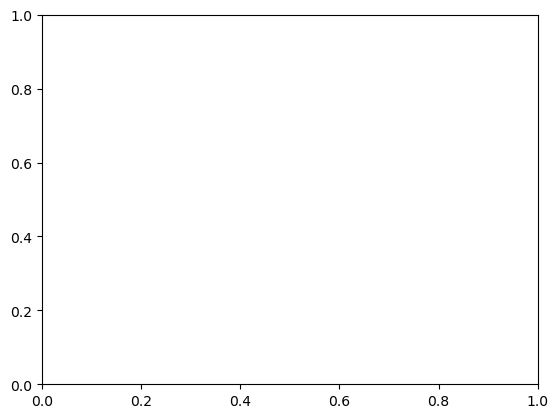

In [39]:
#Plot Results
x_axis = [i for i in range(0, EPOCH)]

plt.plot(x_axis, da_acc, label="source accuracy")
plt.plot(x_axis, test_acc, label="testing accuracy")
plt.plot(x_axis, test2_acc, label="target accuracy")
plt.legend()